In [100]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky 
from matplotlib import cm
from astropy.io import ascii, fits
import astropy.coordinates as coord
import astropy.table as atpy
import astropy.units as u
import plotly
import plotly.graph_objs as go
from astropy.visualization import make_lupton_rgb
import random 

In [14]:
# set paths to maps
path90 = "/Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f090_daynight_map.fits"
path150 = "/Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f150_daynight_map.fits"
path220 = "/Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f220_daynight_map.fits"

In [15]:
f90 = fits.open(path90)
f90.info()

Filename: /Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f090_daynight_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FREQ-MAP      1 PrimaryHDU      45   (43200, 10320, 3)   float32   


In [72]:
f90[0].header['freq']

'f090'

In [47]:
data = f90[0].data

In [50]:
data.shape

(3, 10320, 43200)

In [5]:
def eshow(x,**kwargs): 
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [137]:
ra_from, ra_to = np.deg2rad([0, 50])
dec_from, dec_to = np.deg2rad([-10,20])

box = [[dec_from,ra_from],[dec_to,ra_to]]

imap90 = enmap.read_map(path90, box = box)
imap150 = enmap.read_map(path150, box = box)
imap220 = enmap.read_map(path220, box = box)

In [29]:
imap90.shape

(3, 4200, 7200)

In [75]:
freqs = [(imap90, 90), (imap150, 150), (imap220, 220)]

In [139]:
tab = atpy.Table().read('DR5_cluster-catalog_v1.1.fits')
ras = tab['RADeg']
decs = tab['decDeg']
mass = tab['M500c']

(0.0, 3.141592653589793)

0.11353258697939313 -1.0448114201355254
6.6619263310970895 4.705973798419659
21.79843160405571 -16.429005677245385
14.522713127451286 0.5182195274801793
42.055121258042455 2.636086468926523


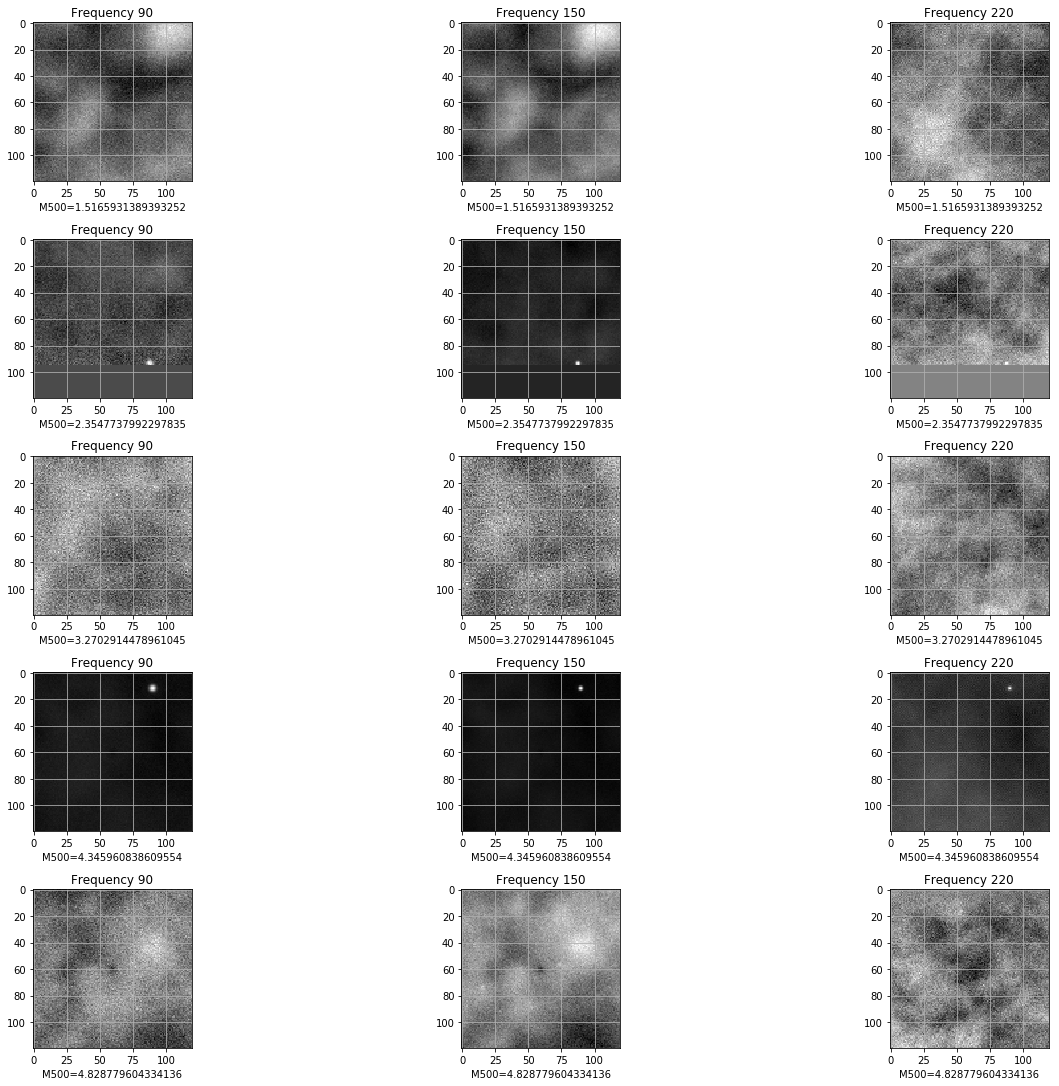

In [153]:
ns = [4, 159, 544, 345, 1129]
width = 60/60.

fig, axs = plt.subplots(len(ns), 3, figsize=(18, 15))
for i in range(len(ns)):
    ra, dec = [ras[ns[i]],decs[ns[i]]]
    print(ra,dec)
    box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
    fig.tight_layout()
    for j, imap in enumerate(freqs):
        axs[i][j].imshow(imap[0][0].submap(box), cmap='gray')
        axs[i][j].set_title('Frequency {}'.format(imap[1]))
        axs[i][j].set_xlabel("M500={}".format(mass[ns[i]]))
        axs[i][j].grid(True)

Text(0.5, 0, 'Degrees')

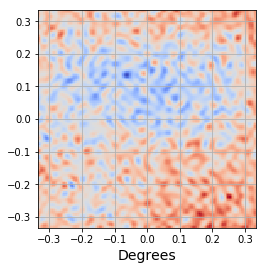

In [107]:
r_arcmin = 10.  #Define the radius of the image in arcminutes
r = r_arcmin*np.pi/(60 * 180)  # convert arcminutes to radians 

stamp = reproject.thumbnails(imap90, coords = np.deg2rad([decs[n], ras[n]]), res =  0.0000454440, r = r)


extent = [-r_arcmin/30., r_arcmin/30., -r_arcmin/30., r_arcmin/30.]
plt.imshow(stamp[0], extent=extent,cmap = cm.coolwarm)
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)

Text(0.5, 0, 'Degrees')

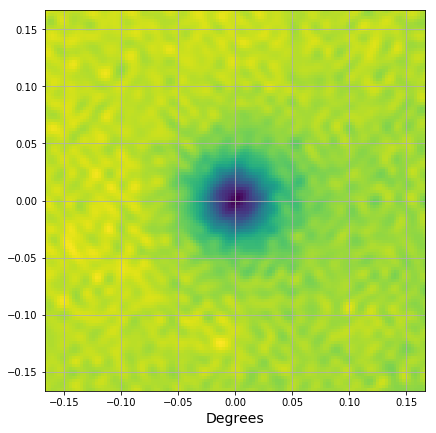

In [95]:
stamps = reproject.thumbnails(imap90[0], coords=np.deg2rad([decs,ras]).T, res=0.0000454440, r=r)
stack = np.mean(stamps,0)

plt.figure(figsize = (7,7))
plt.imshow(stack, extent = extent)
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)

In [103]:
from astropy.cosmology import WMAP9 as cosmo

r = cosmo.comoving_distance(tab['redshift'])
theta=np.radians(tab['RADeg'])
phi=np.radians(90-tab['decDeg'])

x=r*np.cos(theta)*np.sin(phi)
y=r*np.sin(theta)*np.sin(phi)
z=r*np.cos(phi)

In [105]:
plotly.offline.init_notebook_mode()
trace = go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker={'size':2*mass, 'opacity': 0.8,}, 
    hovertext=  ["Mass: {} Trillion Solar Masses <br>Redshift: {} "
                 .format(round(tab['M500c'][x], 2)*1e2, 
                 round(tab["redshift"][x], 3)) 
                 for x in range(len(tab['M500c'])) ] )

layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
data = [trace]
fig = go.Figure(data=data)

fig.update_layout(scene = dict(
                    xaxis_title='Mpc',
                    yaxis_title='Mpc',
                    zaxis_title='Mpc'))

plotly.offline.iplot(fig)